In [ ]:
# Transformer 모델내에서 사용되는 워드 임베딩 처리 및 학습
# 학습 목표 
# - 각 단어마다 vocab 전체와 확률 비교 → 정답과 비교 → 손실 계산 → 파라미터 업데이트 → logits 생성이라는 흐름으로 학습
# - 그 과정에서 임베딩이 점점 의미를 반영하게 되고, 비슷한 단어끼리 가까워지는 성질이 생긴다
# - 임베딩 weight 업데이트, 임베딩 행렬의 각 벡터가 학습을 통해 의미 공간에서 위치를 바꾸는 것이다

# 1. 토크나이저 -> 인덱스 변환 
# - 텍스트를 토큰 단위로 분리 (WordPiece, BPE, SentencePiece 등) 
# - 각 토큰을 고유 인덱스로 매핑
# 2. 임베딩 레이어 생성 
# - PyTorch의 nn.Embedding을 사용해 인덱스를 고정 길이 벡터로 변환 
# - 학습 가능한 파라미터로 초기화 -> 학습 과정에서 업데이트 됨 
# 3. 학습 루프 및 임베딩 학습 방식 
# - 랜덤 초기화 후 학습 : 모델 학습 과정에서 임베딩이 점차 의미를 학습 
# - 사전학습 임베딩 활용 : Word2Vec, GloVe, FastText 같은 사전학습 벡터를 초기값으로 사용 
# - Transformer 기반 임베딩 : BERT, GPT 등 사전학습 모델의 임베딩 레이어를 가져와 파인 튜닝

In [62]:
# 1. 토크나이저 -> 인덱스 변환 
# - 텍스트를 토큰 단위로 분리 (WordPiece, BPE, SentencePiece 등) 
# - 각 토큰을 고유 인덱스로 매핑
from transformers import AutoTokenizer

# 작은 코퍼스
corpus = [
    "안녕하세요 오늘은 날씨가 맑습니다",
    "저는 자연어 처리를 공부하고 있습니다",
    "임베딩은 단어를 벡터로 표현하는 방법입니다",
    "파이토치는 딥러닝을 위한 강력한 라이브러리입니다",
    "언어 모델은 다음 단어를 예측하는 방식으로 학습합니다",
    "작은 데이터셋으로도 실험을 시작할 수 있습니다",
    "머신러닝은 데이터를 통해 패턴을 학습합니다",
    "딥러닝은 인공신경망을 기반으로 합니다",
    "토큰화는 문장을 단어 단위로 나누는 과정입니다",
    "모델은 입력을 받아 출력을 생성합니다",
    "하이퍼파라미터는 학습 성능에 큰 영향을 줍니다",
    "에포크는 전체 데이터셋을 한 번 학습하는 단위를 의미합니다",
    "배치 크기는 한 번에 처리하는 샘플 수입니다",
    "손실 함수는 모델의 예측과 정답의 차이를 측정합니다",
    "옵티마이저는 파라미터를 업데이트하는 알고리즘입니다",
    "학습률은 파라미터를 얼마나 크게 조정할지 결정합니다",
    "정규화는 과적합을 방지하는 방법입니다",
    "드롭아웃은 일부 뉴런을 무작위로 끊어 학습을 안정화합니다",
    "GPU는 대규모 연산을 빠르게 수행할 수 있습니다",
    "실험을 반복하면 더 나은 결과를 얻을 수 있습니다"
]

# 사전학습된 gpt2 모델의 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained('gpt2')
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = tokenizer.eos_token

# 토큰화
inputs = tokenizer(corpus, return_tensors='pt', padding=True)

input_ids = inputs['input_ids'] 
vocab_size = tokenizer.vocab_size # 사전학습된 gpt2 모델의 토크나이저 vocabulary 50257 보유
embed_dim = 128 # embedding 128 차원

# 결과 확인
# print(inputs)
print(inputs['input_ids'].shape)
print(vocab_size)
# print(inputs['attention_mask'])

torch.Size([20, 69])
50257


In [ ]:
# 간단한 모델
import torch
import torch.nn as nn

class SimpleLM(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.decoder = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, x):
        emb = self.embedding(x)
        logits = self.decoder(emb)
        return logits

In [64]:
# 모델, 손실함수, 옵티마이저 객체 생성
model = SimpleLM(vocab_size=vocab_size, embed_dim=embed_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 학습 진행

# next-token prediction: 입력과 라벨 어긋나게
inputs_shift = input_ids[:, :-1]
labels_shift = input_ids[:, 1:]

for epoch in range(100):
    optimizer.zero_grad()
    logits = model(inputs_shift)
    # loss = loss_fn(logits.view(-1, vocab_size), labels_shift.view(-1))
    # 학습 루프에서는 .reshape()를 쓰는 게 더 안정적
    loss = loss_fn(logits.reshape(-1, vocab_size), labels_shift.reshape(-1))
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 5.9794
Epoch 1, Loss: 5.9058
Epoch 2, Loss: 5.8338
Epoch 3, Loss: 5.7633
Epoch 4, Loss: 5.6944
Epoch 5, Loss: 5.6268
Epoch 6, Loss: 5.5604
Epoch 7, Loss: 5.4953
Epoch 8, Loss: 5.4312
Epoch 9, Loss: 5.3682
Epoch 10, Loss: 5.3061
Epoch 11, Loss: 5.2450
Epoch 12, Loss: 5.1847
Epoch 13, Loss: 5.1253
Epoch 14, Loss: 5.0667
Epoch 15, Loss: 5.0088
Epoch 16, Loss: 4.9517
Epoch 17, Loss: 4.8954
Epoch 18, Loss: 4.8398
Epoch 19, Loss: 4.7849
Epoch 20, Loss: 4.7307
Epoch 21, Loss: 4.6772
Epoch 22, Loss: 4.6245
Epoch 23, Loss: 4.5724
Epoch 24, Loss: 4.5210
Epoch 25, Loss: 4.4704
Epoch 26, Loss: 4.4204
Epoch 27, Loss: 4.3710
Epoch 28, Loss: 4.3224
Epoch 29, Loss: 4.2744
Epoch 30, Loss: 4.2271
Epoch 31, Loss: 4.1805
Epoch 32, Loss: 4.1345
Epoch 33, Loss: 4.0891
Epoch 34, Loss: 4.0444
Epoch 35, Loss: 4.0003
Epoch 36, Loss: 3.9569
Epoch 37, Loss: 3.9140
Epoch 38, Loss: 3.8718
Epoch 39, Loss: 3.8301
Epoch 40, Loss: 3.7891
Epoch 41, Loss: 3.7486
Epoch 42, Loss: 3.7087
Epoch 43, Loss: 3.669

6 [-0.35824667 -0.27314336]
7 [-0.77610401  0.00821501]


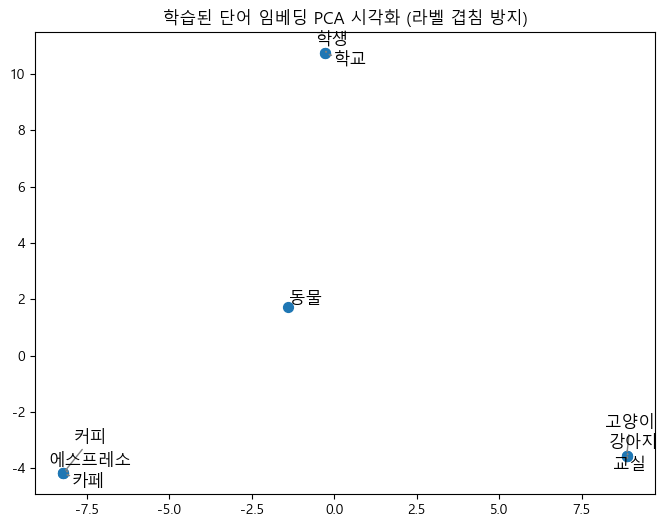

In [ ]:
# 학습된 단어 임베딩 PCA 시각화
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text

# 관심 단어들
words = ["학교","학생","교실","커피","카페","에스프레소","강아지","고양이","동물"]

# 토큰 ID 변환
word_ids = [tokenizer.encode(w, add_special_tokens=False)[0] for w in words]

# 학습된 임베딩 벡터 추출
vectors = model.embedding.weight[word_ids].detach().cpu().numpy()

# PCA로 2차원 축소
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], s=50)

texts = []
for i, word in enumerate(words):
    texts.append(plt.text(reduced[i,0], reduced[i,1], word, fontsize=12))

# 라벨 자동 조정
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray'))

plt.title("학습된 단어 임베딩 PCA 시각화 (라벨 겹침 방지)")
plt.show()

6 [-0.33840882 -0.53441996]
7 [ 0.18560702 -0.88460181]


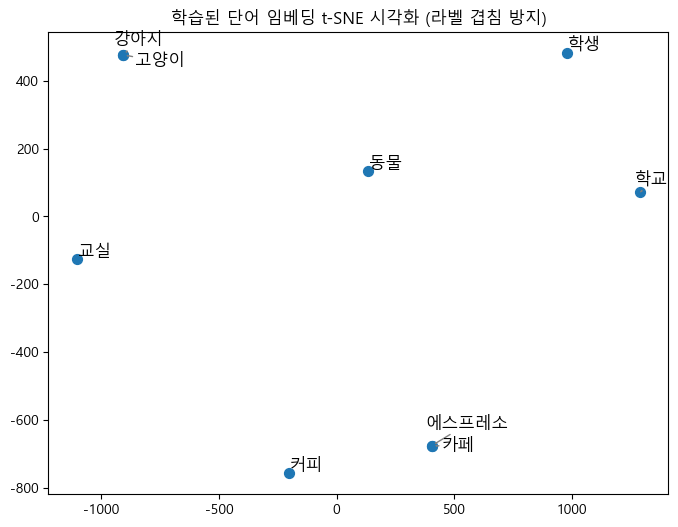

In [ ]:
# 학습된 단어 임베딩 t-SNE 시각화
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from adjustText import adjust_text

# 관심 단어들
words = ["학교","학생","교실","커피","카페","에스프레소","강아지","고양이","동물"]

# 토큰 ID 변환
word_ids = [tokenizer.encode(w, add_special_tokens=False)[0] for w in words]

# 학습된 임베딩 벡터 추출
vectors = model.embedding.weight[word_ids].detach().cpu().numpy()

# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=1000)
reduced = tsne.fit_transform(vectors)

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], s=50)

texts = []
for i, word in enumerate(words):
    texts.append(plt.text(reduced[i,0], reduced[i,1], word, fontsize=12))

# 라벨 자동 조정
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray'))

plt.title("학습된 단어 임베딩 t-SNE 시각화 (라벨 겹침 방지)")
plt.show()

In [ ]:
# 코사인 유사도 행렬
from sklearn.metrics.pairwise import cosine_similarity

# 관심 단어들
words = ["파이토치","딥러닝","GPU"]

# 토큰 ID 변환
word_ids = [tokenizer.encode(w, add_special_tokens=False)[0] for w in words]

# 학습된 임베딩 벡터 추출
vectors = model.embedding.weight[word_ids].detach().cpu().numpy()

# 코사인 유사도 계산
sim_matrix = cosine_similarity(vectors)
print("코사인 유사도 행렬:")
print(sim_matrix)

코사인 유사도 행렬:
[[ 1.         -0.02957549  0.12854913]
 [-0.02957549  1.         -0.08932061]
 [ 0.12854913 -0.08932061  1.0000002 ]]


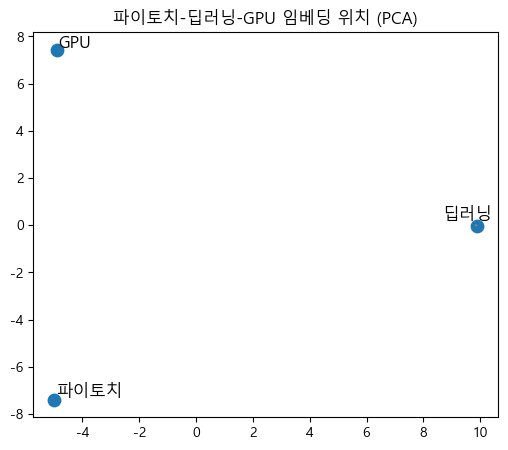

In [ ]:
# 파이토치-딥러닝-GPU 임베딩 위치 (PCA)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text

# PCA로 2차원 축소
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# 시각화
plt.figure(figsize=(6,5))
plt.scatter(reduced[:,0], reduced[:,1], s=80)

texts = []
for i, word in enumerate(words):
    texts.append(plt.text(reduced[i,0], reduced[i,1], word, fontsize=12))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray'))
plt.title("파이토치-딥러닝-GPU 임베딩 위치 (PCA)")
plt.show()